In [1]:
from __future__ import division, print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

%cd HepG2

/users/avanti/interpret-benchmark/data/HepG2


In [2]:
%matplotlib inline

import keras
from keras.models import model_from_json
from keras.models import Model
import h5py
import numpy as np
from deeplift import dinuc_shuffle
from matplotlib import pyplot as plt
import sys
from deeplift.visualization import viz_sequence


argmax_to_letter = {0:'A', 1:'C', 2:'G', 3:'T'}
def onehot_to_seq(onehot):
    seq = "".join([argmax_to_letter[x] for x in np.argmax(onehot,axis=-1)])
    return seq

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


Using TensorFlow backend.


In [36]:

#model_prefix = "record_1_model_v4VYz"
model_prefix = "record_20_model_QFbAM" #dan preinit

#model_prefix = "record_15_model_REDP7" #trained from scratch

model_weights = "model_files/"+model_prefix+"_modelWeights.h5"
model_json = "model_files/"+model_prefix+"_modelJson.json"

keras_model = model_from_json(open(model_json).read())
keras_model.load_weights(model_weights)

preact_model = Model(inputs=keras_model.input,
                     outputs=keras_model.layers[-2].output)

imp_scores_fh = h5py.File("imp_scores_"+model_prefix+".h5", "r")
onehot_seq = np.array(imp_scores_fh['onehot'])
orig_preds = preact_model.predict(onehot_seq).squeeze()

seqs = [onehot_to_seq(x) for x in onehot_seq]
shuffled_onehot_seqs = []
num_shuffles_to_make = 10
for i in range(num_shuffles_to_make):
    shuffled_onehot_seqs.append(np.array(
            [one_hot_encode_along_channel_axis(dinuc_shuffle.dinuc_shuffle(x)) for x in seqs]))

In [37]:
method_to_zerod_diffs = {}
method_to_subbed_diffs = {}

percentile = 90

scoring_methods = [
    'scores_ism',
    'scores_deeplift_rescale_dinucshuff',
    'scores_deeplift_genomicsdefault_dinucshuff',
    'scores_integrated_grad20_dinucshuff',
    'scores_grad_times_inp_flatref',
    
    'scores_integrated_grad20_avgposref',
    'scores_deeplift_rescale_avgposref',
    'scores_deeplift_genomicsdefault_avgposref',
    'scores_integrated_grad20_flatref',
    'scores_deeplift_rescale_flatref',
    'scores_deeplift_genomicsdefault_flatref',
    
    'scores_integrated_grad10_dinucshuff',
    'scores_integrated_grad2_dinucshuff',
    'scores_integrated_grad5_dinucshuff',     
]

for method in scoring_methods:
    #print(method)
    sys.stdout.flush()
    scores = np.array(imp_scores_fh[method])
    central_scores = scores[:,350:650]
    
    #for each example, zero out the top 10% of scores
    
    to_zero = list(zip(*np.nonzero(central_scores > np.percentile(central_scores,percentile))))
    #print(len(to_zero))
    
    #to_zero = [
    #    (i,x) for i,ex_central_scores in enumerate(central_scores)
    #     for x in np.nonzero(ex_central_scores >
    #                         np.percentile(ex_central_scores,percentile))[0]
    #]
    #print(len(to_zero))
    
    zerod_inputs = np.array(onehot_seq)
    for example_idx, col_idx in to_zero:
        zerod_inputs[example_idx,350+col_idx] = 0
        
    subbed_inputs_sets = []
    for i in range(num_shuffles_to_make):
        subbed_inputs = np.array(onehot_seq)
        for example_idx, col_idx in to_zero:
            subbed_inputs[example_idx,350+col_idx] = shuffled_onehot_seqs[i][example_idx,350+col_idx]
        subbed_inputs_sets.append(subbed_inputs)
    mean_subbed_preds = np.mean(np.array([preact_model.predict(x).squeeze() for x in subbed_inputs_sets]),axis=0)
    method_to_subbed_diffs[method] = orig_preds-mean_subbed_preds
    print("avg_diff_meansubbed",method,np.mean(orig_preds-mean_subbed_preds))
    
    #viz_sequence.plot_weights((onehot_seq[0]*scores[0][:,None])[350:650])
    #viz_sequence.plot_weights((altered_inputs[0]*scores[0][:,None])[350:650])
    
    zerod_preds = np.squeeze(preact_model.predict(zerod_inputs))
    method_to_zerod_diffs[method] = orig_preds-zerod_preds
    #print("total_diff_zerod",method,np.sum(orig_preds-zerod_preds))
    
    sys.stdout.flush()
#    plt.hist(central_scores.ravel(),bins=50)
#    plt.show()

avg_diff_meansubbed scores_ism 25.183348
avg_diff_meansubbed scores_deeplift_rescale_dinucshuff 25.934288
avg_diff_meansubbed scores_deeplift_genomicsdefault_dinucshuff 25.455389
avg_diff_meansubbed scores_integrated_grad20_dinucshuff 18.540707
avg_diff_meansubbed scores_grad_times_inp_flatref 21.637545
avg_diff_meansubbed scores_integrated_grad20_avgposref 16.712137
avg_diff_meansubbed scores_deeplift_rescale_avgposref 11.045426
avg_diff_meansubbed scores_deeplift_genomicsdefault_avgposref 11.547295
avg_diff_meansubbed scores_integrated_grad20_flatref 14.17426
avg_diff_meansubbed scores_deeplift_rescale_flatref 19.401318
avg_diff_meansubbed scores_deeplift_genomicsdefault_flatref 15.747534
avg_diff_meansubbed scores_integrated_grad10_dinucshuff 18.522501
avg_diff_meansubbed scores_integrated_grad2_dinucshuff 15.486968
avg_diff_meansubbed scores_integrated_grad5_dinucshuff 15.486968


615
Example_idx 56 pred 45.500668 scores_deeplift_genomicsdefault_dinucshuff_diff 67.09806 scores_ism_diff 29.364729
scores_deeplift_genomicsdefault_dinucshuff imp scores


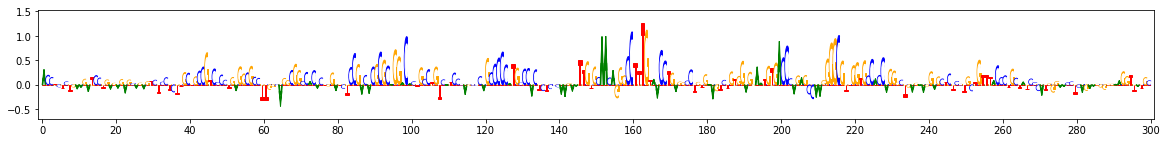

scores_ism imp scores


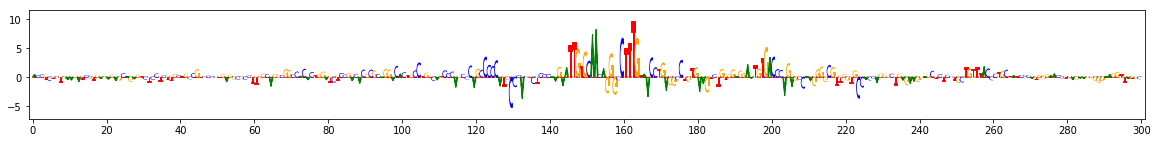

Example_idx 290 pred 33.63912 scores_deeplift_genomicsdefault_dinucshuff_diff 13.980602 scores_ism_diff -3.8146973e-06
scores_deeplift_genomicsdefault_dinucshuff imp scores


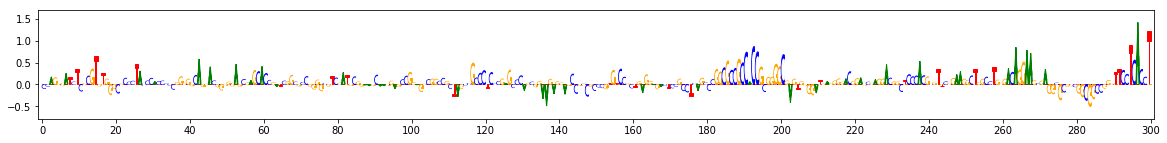

scores_ism imp scores


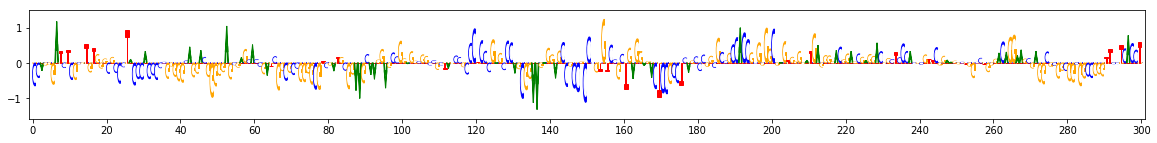

Example_idx 588 pred 22.26368 scores_deeplift_genomicsdefault_dinucshuff_diff 45.666527 scores_ism_diff 36.525814
scores_deeplift_genomicsdefault_dinucshuff imp scores


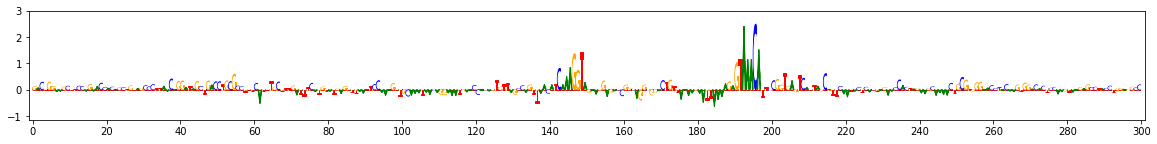

scores_ism imp scores


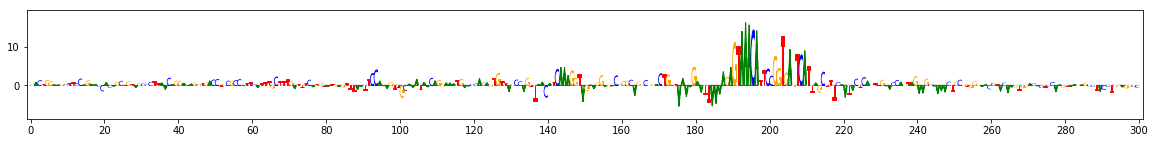

Example_idx 599 pred 21.806257 scores_deeplift_genomicsdefault_dinucshuff_diff 9.326976 scores_ism_diff 3.3142624
scores_deeplift_genomicsdefault_dinucshuff imp scores


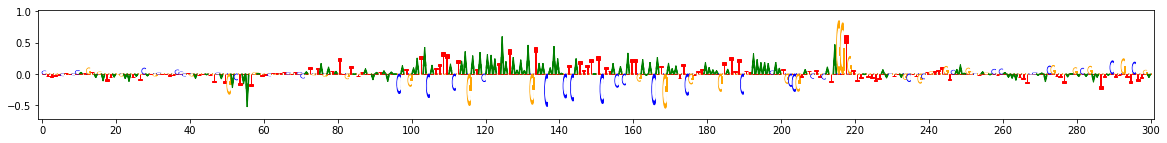

scores_ism imp scores


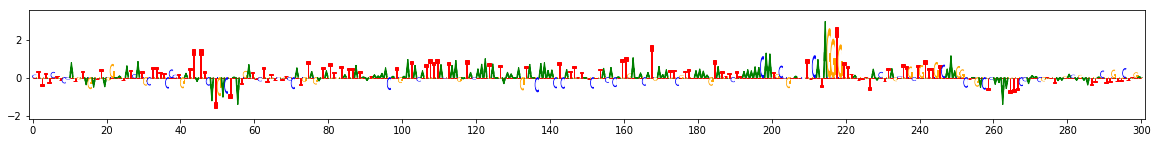

Example_idx 423 pred 28.805696 scores_deeplift_genomicsdefault_dinucshuff_diff 60.105095 scores_ism_diff 57.049416
scores_deeplift_genomicsdefault_dinucshuff imp scores


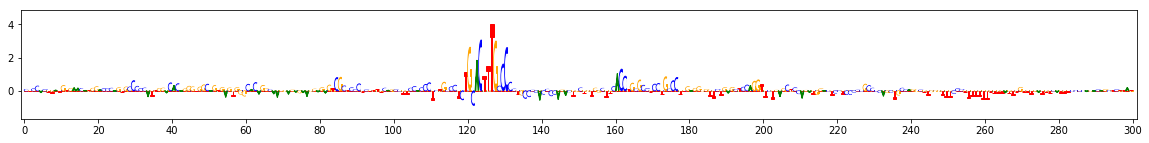

scores_ism imp scores


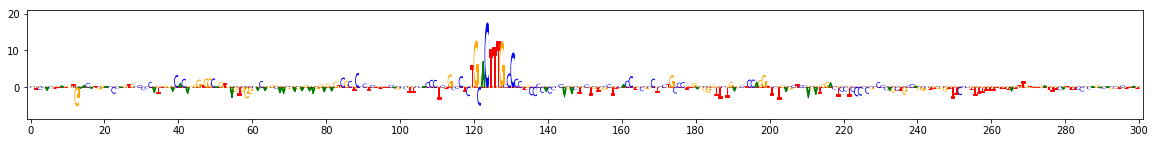

In [38]:
#visualize some examples where one method picks up stuff the other doesn't

def vis_examples_favoring_method_1(method_1_name, method_2_name,
                                   perf_lookup, imp_scores_fh,
                                   onehot_seq,
                                   num_to_plot=3):
    method_1_perfs = perf_lookup[method_1_name]
    method_2_perfs = perf_lookup[method_2_name]
    method_1_minus_method_2_perfs = method_1_perfs - method_2_perfs
    top_method_1_examples = [x[0] for x in sorted(enumerate(method_1_minus_method_2_perfs),
                                   key=lambda x: -x[1]) if x[1] > 0]
    
    method_1_scores = np.array(imp_scores_fh[method_1_name])
    method_2_scores = np.array(imp_scores_fh[method_2_name])
    
    print(len(top_method_1_examples))
    for ex_id in top_method_1_examples[::int(len(top_method_1_examples)/5)]:
        print("Example_idx",ex_id,"pred",orig_preds[ex_id],
              method_1_name+"_diff",method_1_perfs[ex_id],
              method_2_name+"_diff",method_2_perfs[ex_id])
        print(method_1_name+" imp scores")
        viz_sequence.plot_weights((onehot_seq[ex_id]*method_1_scores[ex_id][:,None])[350:650],
                                  subticks_frequency=20)
        print(method_2_name+" imp scores")
        viz_sequence.plot_weights((onehot_seq[ex_id]*method_2_scores[ex_id][:,None])[350:650],
                                  subticks_frequency=20)

vis_examples_favoring_method_1(method_1_name="scores_deeplift_genomicsdefault_dinucshuff",
                               method_2_name="scores_ism",
                               perf_lookup=method_to_subbed_diffs,
                               imp_scores_fh=imp_scores_fh,
                               onehot_seq=onehot_seq)

596
Example_idx 415 pred 29.07968 scores_ism_diff 40.728798 scores_deeplift_rescale_dinucshuff_diff 14.396319
scores_ism imp scores


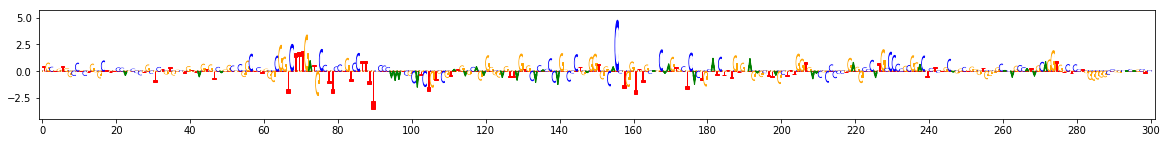

scores_deeplift_rescale_dinucshuff imp scores


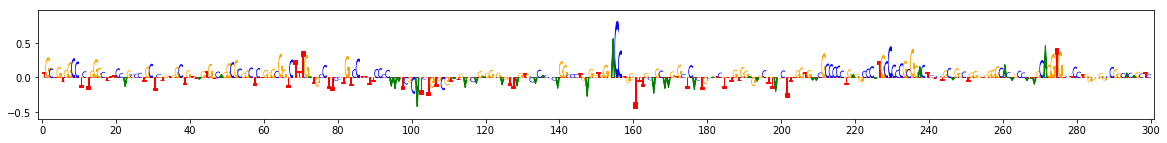

Example_idx 1152 pred -14.385815 scores_ism_diff 14.710737 scores_deeplift_rescale_dinucshuff_diff 6.118948
scores_ism imp scores


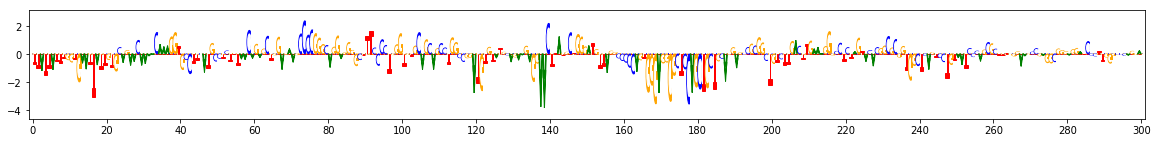

scores_deeplift_rescale_dinucshuff imp scores


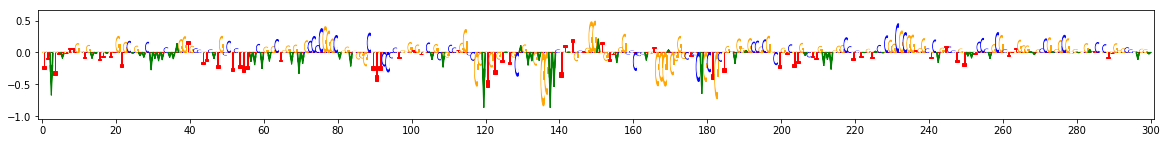

Example_idx 824 pred 11.437463 scores_ism_diff 49.12358 scores_deeplift_rescale_dinucshuff_diff 43.72757
scores_ism imp scores


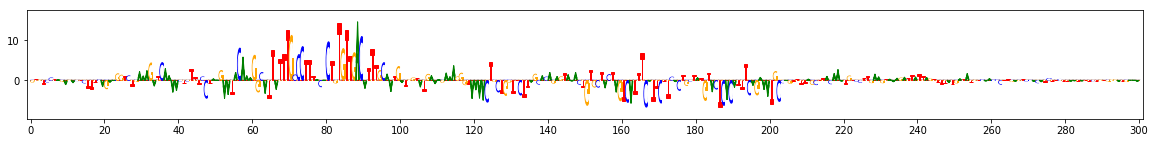

scores_deeplift_rescale_dinucshuff imp scores


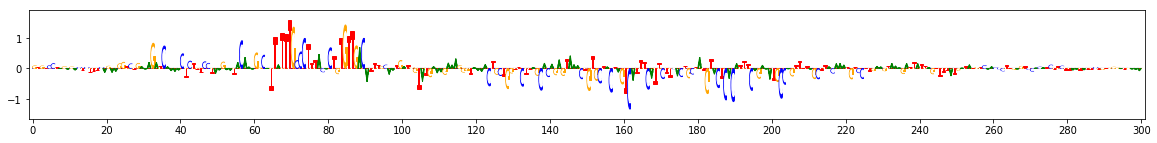

Example_idx 864 pred 9.626899 scores_ism_diff 29.029388 scores_deeplift_rescale_dinucshuff_diff 25.675575
scores_ism imp scores


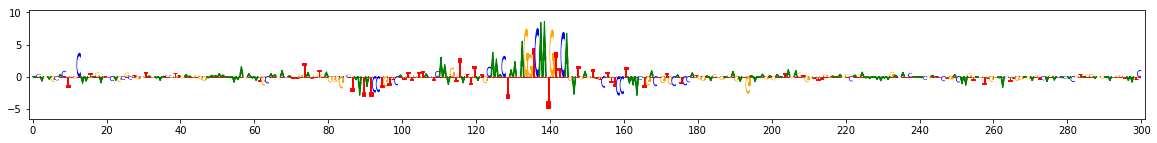

scores_deeplift_rescale_dinucshuff imp scores


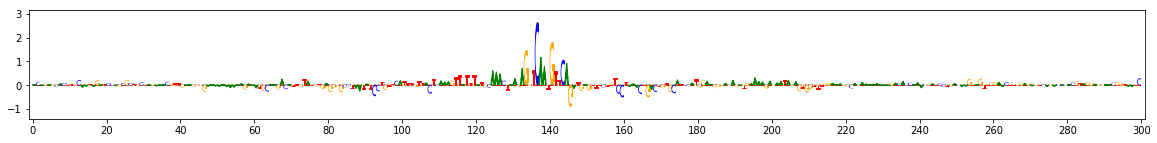

Example_idx 422 pred 28.830795 scores_ism_diff 4.6311436 scores_deeplift_rescale_dinucshuff_diff 3.11174
scores_ism imp scores


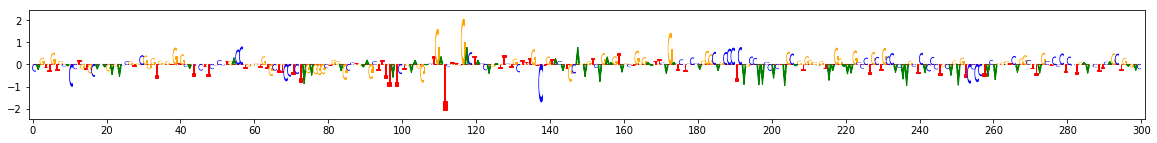

scores_deeplift_rescale_dinucshuff imp scores


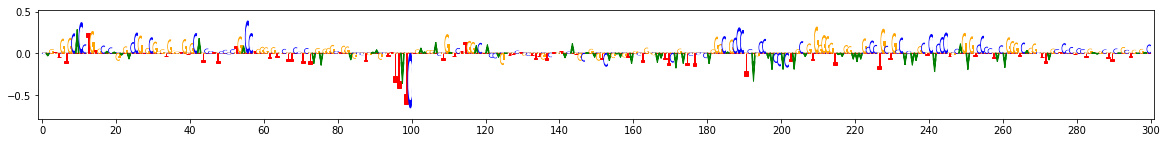

Example_idx 1033 pred 0.00834683 scores_ism_diff 27.871548 scores_deeplift_rescale_dinucshuff_diff 27.871487
scores_ism imp scores


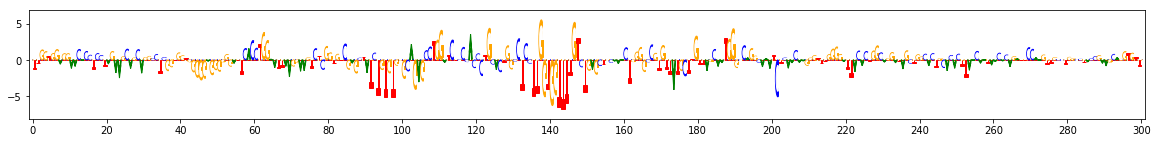

scores_deeplift_rescale_dinucshuff imp scores


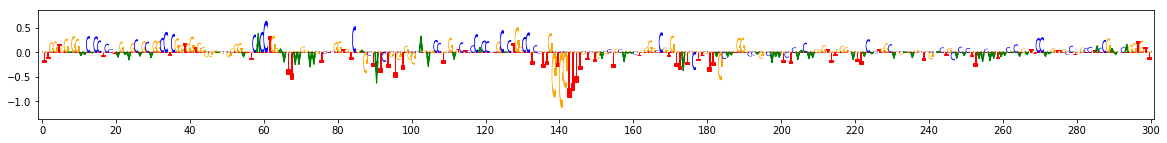

In [41]:
vis_examples_favoring_method_1(method_1_name="scores_ism",
                               method_2_name="scores_deeplift_rescale_dinucshuff",
                               perf_lookup=method_to_subbed_diffs,
                               imp_scores_fh=imp_scores_fh,
                               onehot_seq=onehot_seq)

Compare to ISM


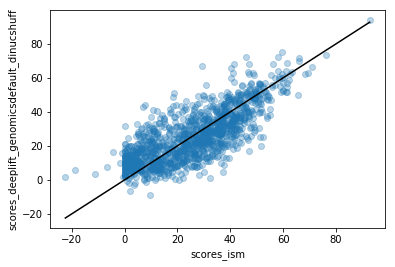

pos ranks sum 390598 neg ranks sum 378822
WilcoxonResult(statistic=378822.5, pvalue=0.6406463764520257)


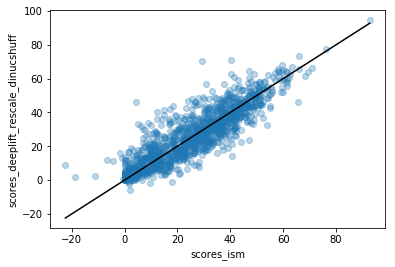

pos ranks sum 409692 neg ranks sum 359725
WilcoxonResult(statistic=358533.5, pvalue=0.04748578028556311)


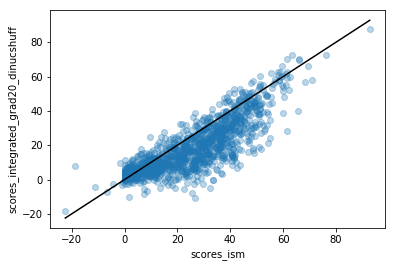

pos ranks sum 114281 neg ranks sum 655139
WilcoxonResult(statistic=114281.0, pvalue=5.519136139660453e-102)


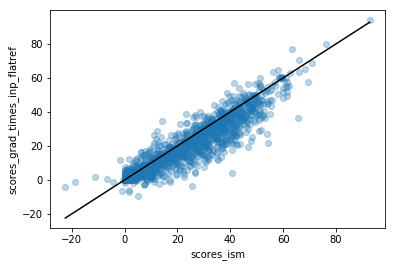

pos ranks sum 169772 neg ranks sum 599512
WilcoxonResult(statistic=163996.0, pvalue=3.713252088519201e-65)
Dinuc shuff ref is better


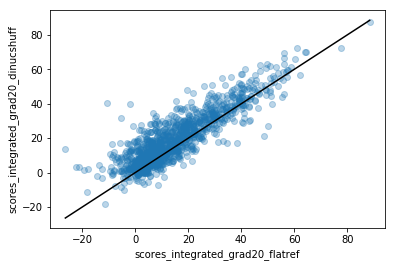

pos ranks sum 624699 neg ranks sum 144721
WilcoxonResult(statistic=144721.0, pvalue=1.0052507501785255e-80)


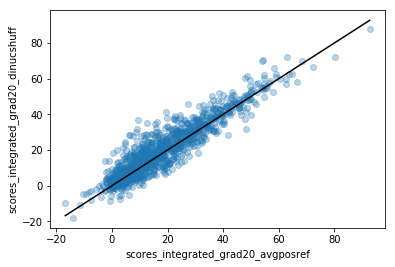

pos ranks sum 524186 neg ranks sum 245234
WilcoxonResult(statistic=245234.0, pvalue=1.9947411584503262e-28)
Intgrad vs deeplift


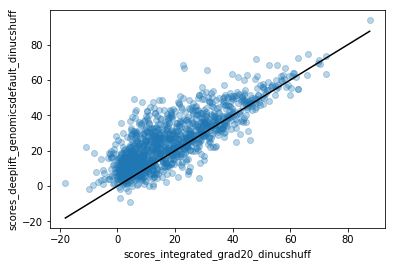

pos ranks sum 664702 neg ranks sum 104718
WilcoxonResult(statistic=104718.0, pvalue=3.4810803642104725e-109)


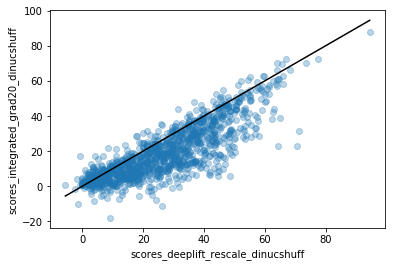

pos ranks sum 80709 neg ranks sum 688711
WilcoxonResult(statistic=80709.0, pvalue=2.326877445174894e-128)
Deeplift revealcancel vs rescale


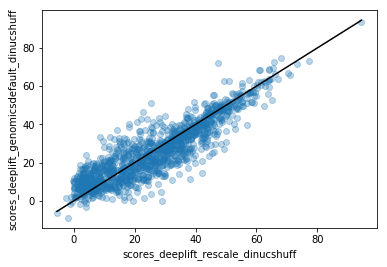

pos ranks sum 353058 neg ranks sum 416362
WilcoxonResult(statistic=353058.0, pvalue=0.012088349948922567)
Grad times inp vs intgrad


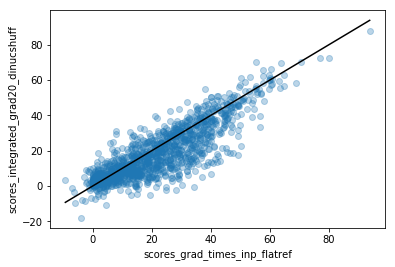

pos ranks sum 242023 neg ranks sum 527396
WilcoxonResult(statistic=241545.0, pvalue=1.100029189159187e-29)
Intgrad 2 vs 20


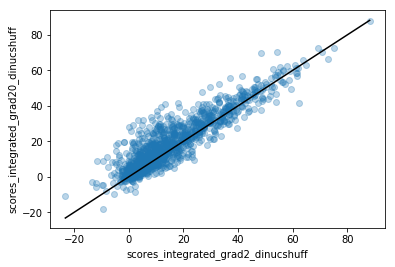

pos ranks sum 576674 neg ranks sum 192743
WilcoxonResult(statistic=191951.0, pvalue=2.543268485816353e-52)
Intgrad 5 vs 20


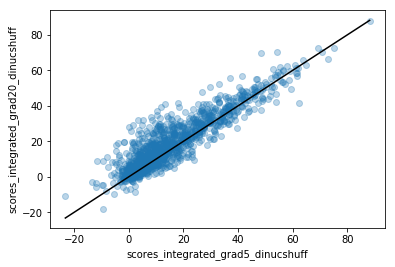

pos ranks sum 576674 neg ranks sum 192743
WilcoxonResult(statistic=191951.0, pvalue=2.543268485816353e-52)


In [39]:
import scipy
from scipy import stats

def compare_methods(method_1_name, method_2_name, score_lookup):
    method_1_scores=score_lookup[method_1_name]
    method_2_scores=score_lookup[method_2_name]
    plt.scatter(method_1_scores, method_2_scores, alpha=0.3)
    plt.plot([np.min(method_1_scores), np.max(method_1_scores)],
             [np.min(method_1_scores), np.max(method_1_scores)],
             color="black")
    plt.xlabel(method_1_name)
    plt.ylabel(method_2_name)
    plt.show()
    differences = method_2_scores-method_1_scores
    sorted_differences = sorted(differences,key=lambda x:np.abs(x))
    #print(sorted_differences)
    positive_ranks = sum([x[0]+1 for x in enumerate(sorted_differences) if x[1] > 0])
    negative_ranks = sum([x[0]+1 for x in enumerate(sorted_differences) if x[1] < 0])
    print("pos ranks sum",positive_ranks, "neg ranks sum", negative_ranks)
    print(scipy.stats.wilcoxon(differences))
    
diffs_lookup = method_to_subbed_diffs    

print("Compare to ISM")

compare_methods(method_1_name="scores_ism",
                method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                score_lookup=diffs_lookup)
compare_methods(method_1_name="scores_ism",
                method_2_name="scores_deeplift_rescale_dinucshuff",
                score_lookup=diffs_lookup)
compare_methods(method_1_name="scores_ism",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=diffs_lookup)
compare_methods(method_1_name="scores_ism",
                method_2_name="scores_grad_times_inp_flatref",
                score_lookup=diffs_lookup)

print("Dinuc shuff ref is better")
compare_methods(method_1_name="scores_integrated_grad20_flatref",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=diffs_lookup)
compare_methods(method_1_name="scores_integrated_grad20_avgposref",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=diffs_lookup)

print("Intgrad vs deeplift")

compare_methods(method_1_name="scores_integrated_grad20_dinucshuff",
                method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                score_lookup=diffs_lookup)

compare_methods(method_1_name="scores_deeplift_rescale_dinucshuff",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=diffs_lookup)

print("Deeplift revealcancel vs rescale")

compare_methods(method_1_name="scores_deeplift_rescale_dinucshuff",
                method_2_name="scores_deeplift_genomicsdefault_dinucshuff",
                score_lookup=diffs_lookup)


print("Grad times inp vs intgrad")
compare_methods(method_1_name="scores_grad_times_inp_flatref",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=diffs_lookup)

print("Intgrad 2 vs 20")
compare_methods(method_1_name="scores_integrated_grad2_dinucshuff",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=diffs_lookup)

print("Intgrad 5 vs 20")
compare_methods(method_1_name="scores_integrated_grad5_dinucshuff",
                method_2_name="scores_integrated_grad20_dinucshuff",
                score_lookup=diffs_lookup)
